<a id="2"></a>
# Modeling the Results of Pulls for UR+ Shards Using Monte Carlo Simulations
Credit to **VoidTwo** (_voidtwo on Discord_) for writing the code<br>
Report written by Nillabutt<br>
February 8, 2024

[*jump to the tables*](#1)

In [1]:
# Future imports
from __future__ import annotations

# Standard imports
from collections import defaultdict
from multiprocessing.pool import Pool as mp_Pool
from secrets import randbelow as secrets_randbelow
from typing import TYPE_CHECKING

# 3rd party imports
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

In [2]:
# Type checking
if TYPE_CHECKING:
    from typing import (
        ClassVar,
        Final)

    from matplotlib.axes import Axes

In [3]:
class SummonInfo:
    shard_probability_range: ClassVar[int] = 100_000
    shard_probability_threshold: ClassVar[dict[int, int]] = {
        1: 23_841,  # 23.841%
        2: 31_126,  # 7.285%
        5: 33_775}  # 2.649%
    shard_probability_order: ClassVar[tuple[int, ...]] = (
        1, 2, 5)

    shard_pities: ClassVar[dict[int, int]] = {
        1: 6,
        2: 16,
        5: 65}
    shard_pity_floors: ClassVar[dict[int, int]] = {
        1: 6,
        2: 15,
        5: 58}
    shard_pity_priority: ClassVar[tuple[int, ...]] = (
        5, 2, 1)

    shard_goal: ClassVar[int] = 265

    __slots__: tuple[str, ...] = ()

    def __init__(self) -> None:
        return


class SummonProgress:
    __slots__: tuple[str, ...] = (
        '__pity_counts',
        '__accumulated_shards')

    def __init__(self) -> None:
        shard_count: int
        self.__pity_counts: Final[dict[int, int]] = dict(
            (shard_count, 1) for shard_count in SummonInfo.shard_pity_priority)
        self.__accumulated_shards: int = 0
        return

    def __str__(self) -> str:
        return (
            f'__pity_counts: {self.__pity_counts}\n'
            f'__accumulated_shards: {self.__accumulated_shards}')

    @property
    def accumulated_shards(self) -> int:
        return self.__accumulated_shards

    def add_shards(self, shard_count: int) -> None:
        self.__accumulated_shards += shard_count
        return

    def get_pity_count(self, shard_count: int) -> int:
        return self.__pity_counts[shard_count]

    def add_pity(self, shard_count: int) -> None:
        self.__pity_counts[shard_count] += 1
        return

    def reset_pity(self, shard_count: int) -> None:
        self.__pity_counts[shard_count] = 1
        return

In [4]:
def simulate_summon(summon_progress: SummonProgress) -> None:
    add_shards: int = 0
    shard_count: int

    for shard_count in SummonInfo.shard_pity_priority:
        if summon_progress.get_pity_count(shard_count) >= SummonInfo.shard_pities[shard_count]:
            summon_progress.reset_pity(shard_count)
            add_shards = shard_count
            break

    if add_shards == 0:
        random_value: int = secrets_randbelow(SummonInfo.shard_probability_range)
        threshold_expired: bool = False

        for shard_count in SummonInfo.shard_probability_order:
            if add_shards == 0 \
                    and not threshold_expired \
                    and random_value < SummonInfo.shard_probability_threshold[shard_count]:
                threshold_expired = True

                if summon_progress.get_pity_count(shard_count) >= SummonInfo.shard_pity_floors[shard_count]:
                    summon_progress.reset_pity(shard_count)
                    add_shards = shard_count
                    continue

            summon_progress.add_pity(shard_count)
    else:
        for shard_count in SummonInfo.shard_pity_priority:
            if shard_count != add_shards:
                summon_progress.add_pity(shard_count)

    summon_progress.add_shards(add_shards)
    return

In [5]:
def fully_summon(_: int) -> int:
    summon_progress: SummonProgress = SummonProgress()
    summon_count: int = 0

    while summon_progress.accumulated_shards < SummonInfo.shard_goal:
        simulate_summon(summon_progress)
        summon_count += 1
        # print(f'Summon #{summon_count}: {summon_progress.accumulated_shards}')
    return summon_count

In [13]:
def blues(target) -> None:
    SummonInfo.shard_goal = target
    iterations: Final[int] = 20000
    results: defaultdict = defaultdict(int)
    pool: mp_Pool
    summon_count: int

    for summon_count in map(fully_summon, range(iterations)):
        results[summon_count] += 1

    result_summon_counts: list[int] = []
    result_summon_count_counts: list[int] = []
    summon_count_count: int

    for summon_count, summon_count_count in sorted(results.items()):
        result_summon_counts.append(summon_count)
        result_summon_count_counts.append(summon_count_count)
    
    cmap = plt.get_cmap('autumn')
    
    results_df: DataFrame = pd.DataFrame({'Blue Scrolls': result_summon_counts, 'Likelihood': result_summon_count_counts})
    color_length = len(results_df['Blue Scrolls'])
    result_ax: Axes = results_df.plot.bar(x='Blue Scrolls', y='Likelihood', legend=None, color=cmap(np.linspace(0.1,0.9,color_length)))
    
    plt.title(f"Probability Distribution of Pulls for {target} UR+ Shards")
    plt.show()
    print(results_df)
    blue_max = results_df["Blue Scrolls"].max()
    blue_min = results_df["Blue Scrolls"].min()
    results_df["Weighted"] = results_df["Likelihood"] * results_df["Blue Scrolls"]
    average_blues = results_df["Weighted"].sum() / iterations
    blue_freq_max = results_df["Likelihood"].max()
    blue_mode = results_df.loc[results_df["Likelihood"] == blue_freq_max, "Blue Scrolls"].iloc[0]
    print(F"Iterations: {iterations}")
    print(f"Min:  {blue_min} blues")
    print(f"Max:  {blue_max} blues")
    print(f"Mean: {average_blues} blues")
    print(f"Mode: {blue_mode} blues")
    return

<a id="1"></a>
# Running the Simulations (20,000 iterations)

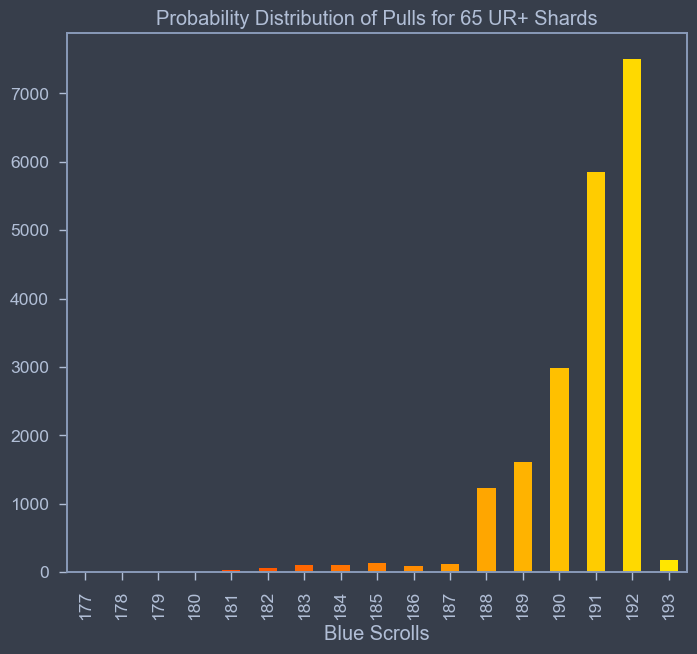

    Blue Scrolls  Likelihood
0            177           5
1            178           3
2            179           2
3            180           3
4            181          34
5            182          62
6            183         102
7            184         105
8            185         129
9            186          90
10           187         112
11           188        1232
12           189        1608
13           190        2980
14           191        5845
15           192        7505
16           193         183
Iterations: 20000
Min:  177 blues
Max:  193 blues
Mean: 190.6846 blues
Mode: 192 blues


In [14]:
# Blues for 65 shards (0 star)
blues(65)

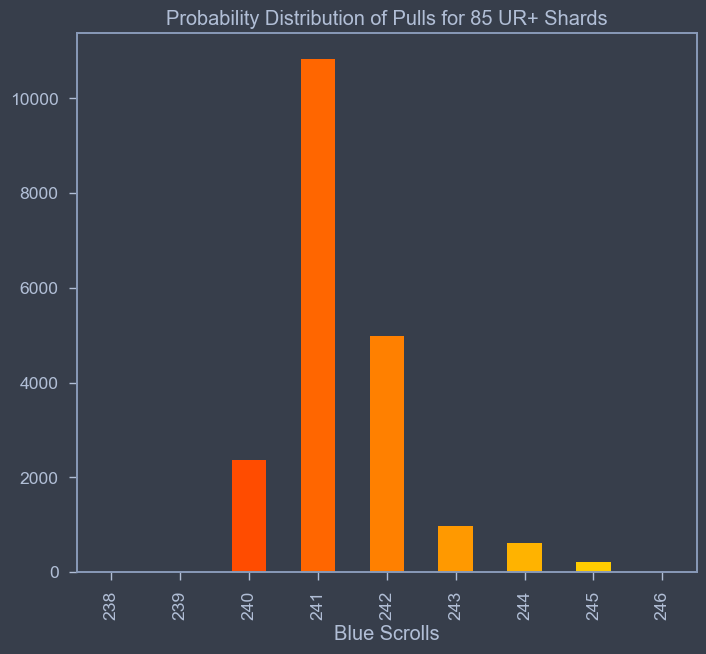

   Blue Scrolls  Likelihood
0           238           2
1           239           1
2           240        2374
3           241       10837
4           242        4979
5           243         984
6           244         614
7           245         207
8           246           2
Iterations: 20000
Min:  238 blues
Max:  246 blues
Mean: 241.36225 blues
Mode: 241 blues


In [15]:
# Blues for 85 shards (1 star)
blues(85)

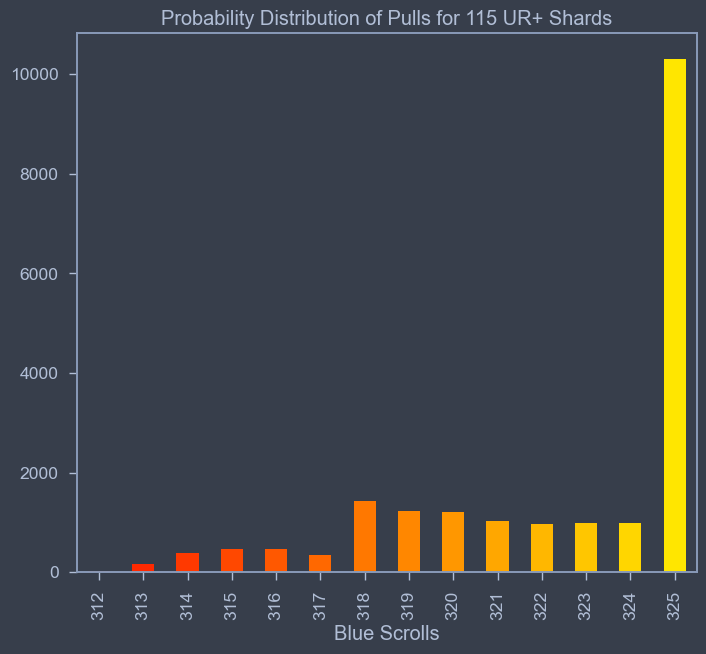

    Blue Scrolls  Likelihood
0            312          17
1            313         170
2            314         386
3            315         470
4            316         460
5            317         353
6            318        1428
7            319        1233
8            320        1204
9            321        1032
10           322         968
11           323         986
12           324         983
13           325       10310
Iterations: 20000
Min:  312 blues
Max:  325 blues
Mean: 322.4214 blues
Mode: 325 blues


In [16]:
# Blues for 115 shards (2 star)
blues(115)

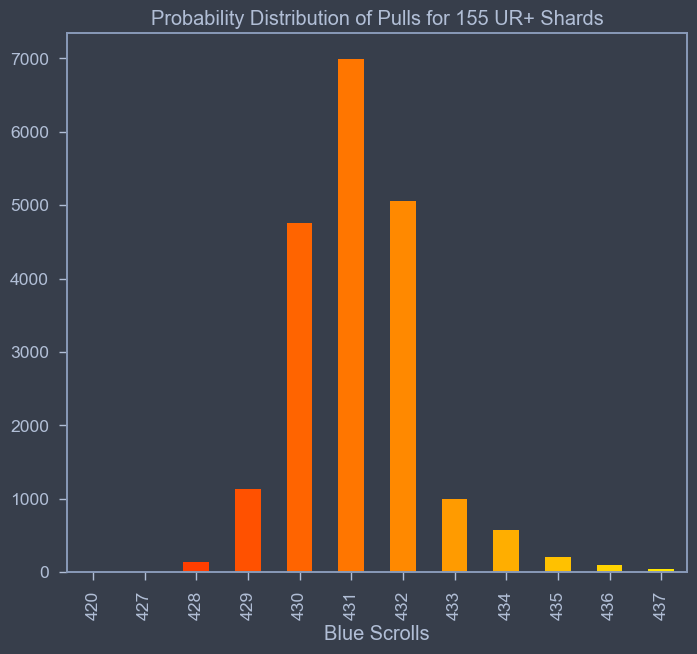

    Blue Scrolls  Likelihood
0            420           1
1            427           6
2            428         143
3            429        1127
4            430        4754
5            431        6994
6            432        5057
7            433         993
8            434         578
9            435         209
10           436          99
11           437          39
Iterations: 20000
Min:  420 blues
Max:  437 blues
Mean: 431.1435 blues
Mode: 431 blues


In [17]:
# Blues for 160 shards (3 star)
blues(155)

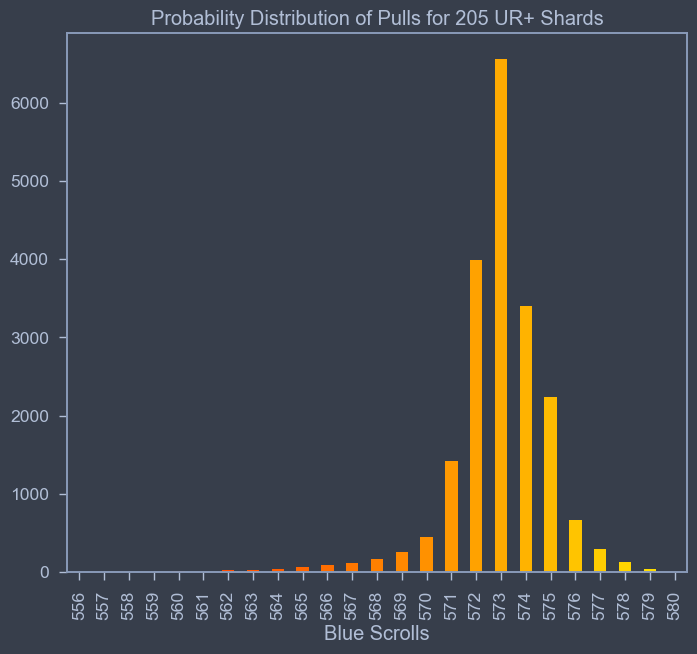

    Blue Scrolls  Likelihood
0            556           3
1            557           3
2            558           3
3            559           4
4            560          10
5            561           8
6            562          21
7            563          30
8            564          42
9            565          60
10           566          94
11           567         115
12           568         172
13           569         253
14           570         452
15           571        1423
16           572        3988
17           573        6559
18           574        3399
19           575        2233
20           576         668
21           577         294
22           578         125
23           579          36
24           580           5
Iterations: 20000
Min:  556 blues
Max:  580 blues
Mean: 572.9348 blues
Mode: 573 blues


In [18]:
# Blues for 210 shards (4 star)
blues(205)

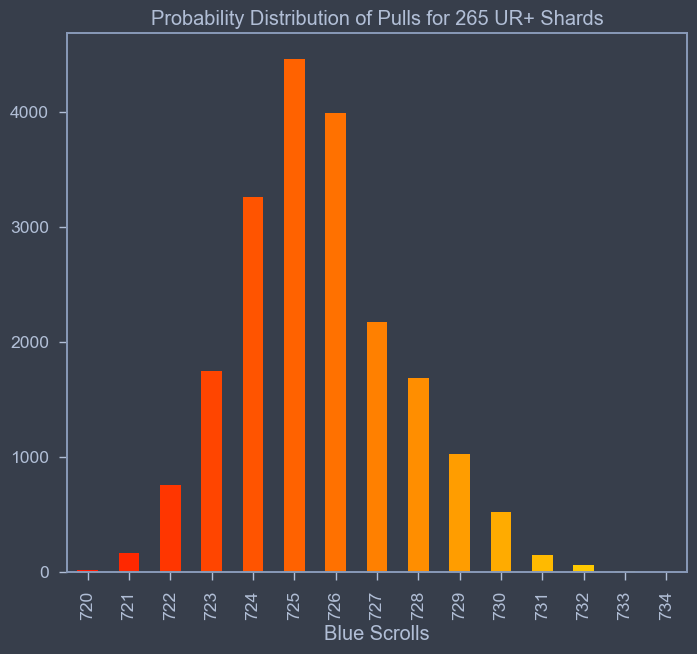

    Blue Scrolls  Likelihood
0            720          16
1            721         162
2            722         754
3            723        1744
4            724        3255
5            725        4458
6            726        3991
7            727        2168
8            728        1686
9            729        1024
10           730         520
11           731         149
12           732          63
13           733           8
14           734           2
Iterations: 20000
Min:  720 blues
Max:  734 blues
Mean: 725.58825 blues
Mode: 725 blues


In [19]:
# Blues for 270 shards (5 star)
blues(265)

[*Back to Top*](#2)